# Fraud detection in bank transactions

---
### Motivation
The customer is an issuing bank seeking a machine learning solution to solve a growing fraud problem.

The bank’s customers are having their cards defrauded and their money is being spent by fraudsters. This is causing customer dissatisfaction, so the bank is looking into introducing better transactional monitoring on activity on their customers’ cards. 

They plan to have a small team of fraud analysts who review risky-looking purchases and decide whether to allow or block the transaction. This team will have the capacity to review 400 transactions a month. The scores from my model will be used to decide which transactions the fraud analysts should review. 

**The bank has provided 1 year of historical transactional data and fraud flags and asked me to build a model which predicts the likelihood that a transaction is later marked as fraud**. 

---
### Summary 
The goal of this study is the selection of a machine learning pipeline to predict the probability of future frauds based on trasactions features. 

After exploring the data, I created many diffent new features and tested several classification algorithms (supervised and unsupervised). 

I found that a Random Forest Classifier produces the best performance. 

I optimized the hyperparameters of this classifier and estimated the performance on the test set. 

Overall, using this model our client will detect 15 times more frauds than by randomly selecting the transactions to check. 

I also show that what is limiting the detection of new frauds is that the data change significantly across time. If we were trying to predict fraud over the same time period as the trainig set, the peformance of the model would be 3 times better.  

I also start optimizing a shallow neural network for the same task, but for now it underperforms the Random Foreset classifier.  

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit, StratifiedShuffleSplit
from sklearn.feature_selection import mutual_info_classif

# models 
from sklearn.svm import SVC, NuSVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras

/home/bienvenue/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/bienvenue/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


## Data importation and formatting

In [2]:
data = pd.read_csv('transactions_obf.csv')
target = pd.read_csv('labels_obf.csv')
print('data loaded')
#----------------------
# Labels Preparation
#----------------------
# Fomat tareget labels: 
# fraud labels are provided as events. 
# To train models we need to convert them to 
# a list of 0 or 1 for each transaction
ind_dict = dict((k,i) for i,k in enumerate(data.eventId))
inter = set(ind_dict).intersection(target.eventId)
indices = [ ind_dict[x] for x in inter ]
indices.sort()
y = np.zeros(data.shape[0])
y[indices] = 1

data loaded


## Data Exploration

In [3]:
data.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118621 entries, 0 to 118620
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   transactionTime    118621 non-null  object 
 1   eventId            118621 non-null  object 
 2   accountNumber      118621 non-null  object 
 3   merchantId         118621 non-null  object 
 4   mcc                118621 non-null  int64  
 5   merchantCountry    118621 non-null  int64  
 6   merchantZip        95616 non-null   object 
 7   posEntryMode       118621 non-null  int64  
 8   transactionAmount  118621 non-null  float64
 9   availableCash      118621 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 9.1+ MB


#### Comment 1
there are ~120.000 transactions

there are 10 features: 9 are categorical (objects and integers) and 1 continuous ('transactionAmount')

Let's check more in detail the continuous one:

---

In [5]:
data['transactionAmount'].describe()

count    118621.000000
mean         53.674774
std         183.665315
min          -0.150000
25%           8.030000
50%          20.250000
75%          49.000000
max       13348.000000
Name: transactionAmount, dtype: float64

---

### Check for null data

In [6]:
data.isnull().sum()

transactionTime          0
eventId                  0
accountNumber            0
merchantId               0
mcc                      0
merchantCountry          0
merchantZip          23005
posEntryMode             0
transactionAmount        0
availableCash            0
dtype: int64

**Dealing with null values**: 

There are 23005 null values in the columns 'merchantZip' (i.e., zip code of merchants).

I cannot extrapolates these values therefore I am going to encode them as a category (see below when I encode this feature with "labelEncoder"). 

---

### Check for duplicated transactions

In [7]:
any(data.duplicated())

False

---

### Check for Labels distribution

overall there are only 875 frauds!! (0.74%)


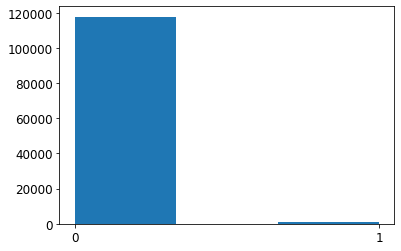

In [8]:
plt.hist(y, bins=3)
plt.xticks([0,1])

print(f'overall there are only {int(sum(y))} frauds!! ({ round(sum(y)*100/len(y),2)}%)')

#### Comment: 
As expected, labels are very unbalanced. 

There are many ways to deal with unbalanced data. 
For example, weighting more or generate more instances for the under-represented category. 

I have tried several of these approaches but they did not help here. I am not going to show these attepts to keep this notebook reasonably long. 

---


#### NB: Accuracy is not a good metric for unbalanced data!!
Since frauds are only the 1% of the total, by predicting always no-frauds we would have always a 99% accuracy.

Therefore, I am going to use the f1 score and the Area under the ROC curve (AUC) instead. Furthermore, I am going to quatify the percent frauds detected from the 400 transactions more likely to be frauds each month

---

### Summary info about frauds

Here I check the distributions of: 
1. transactions/frauds across time, 
2. number of frauds per account and 
3. amount of money stolen per account 

In [9]:
# prepare data for display
df = data.copy()
df['transactionTime'] = pd.to_datetime(data['transactionTime'])
df['month']  = df.transactionTime.dt.month

<ipython-input-10-adcb7605fa75>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xx[fraud==1], np.ones(len(xx[fraud==1]))*i, c='r',cmap='cool')


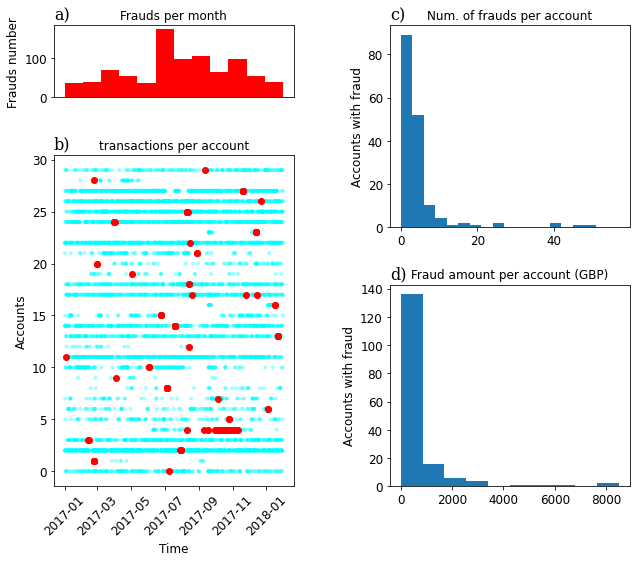

In [10]:
# time-course transactions per account with fraud events 
#-------------------------
mpl.rc('axes', labelsize=12)
col = ['k', 'r']


fig, axs = plt.subplot_mosaic([['a)', 'c)'], 
                               ['b)', 'c)'], 
                               ['b)', 'd)'],
                               ['b)', 'd)']],
                               figsize=(10,8))




#acc_with_frauds = df['accountNumber'].loc[y==1].unique()
plt.axes(axs['b)'])
acc_with_frauds = sorted(df['accountNumber'].loc[y==1].unique().tolist())
for i in range(30):
    acc = acc_with_frauds[i]
    fraud = y[df['accountNumber']==acc]
    xx = df['transactionTime'].loc[df['accountNumber']==acc]
    
    plt.scatter(xx, np.ones(len(xx))*i, marker='.', c=fraud, cmap='cool', alpha=0.3)
   
    plt.scatter(xx[fraud==1], np.ones(len(xx[fraud==1]))*i, c='r',cmap='cool')

plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Accounts')
plt.title('transactions per account')


# Frauds per month
#-------------------------
plt.axes(axs['a)'])
plt.hist(df['transactionTime'].loc[y==1], bins=12, color='r')
plt.xticks([])
plt.ylabel('Frauds number')
plt.title('Frauds per month')


# Number of frauds per account
#-------------------------
label_encoder = LabelEncoder()
df = data.copy()
df.accountNumber = label_encoder.fit_transform(df.accountNumber)
df['transactionTime'] = pd.to_datetime(df['transactionTime'])

num_fraud_per_account = []
for acc in range(max(df['accountNumber'])):
    num_fraud_per_account.append(sum(y[df['accountNumber']==acc]))
num_fraud_per_account = np.array([num_fraud_per_account])


tm = num_fraud_per_account[np.where(num_fraud_per_account>0)]

plt.axes(axs['c)'])
plt.hist(tm, bins=np.arange(0,60,3))
plt.title('Num. of frauds per account')
plt.ylabel('Accounts with fraud')


# Fraud amount per account
#-------------------------
num_accounts_with_fraud = len(num_fraud_per_account[np.where(num_fraud_per_account>0)])
df_fraud = df.loc[y==1] # take only fraud trans.
fraud_amount_per_account = df_fraud.groupby('accountNumber')['transactionAmount'].sum()

plt.axes(axs['d)'])
plt.hist(fraud_amount_per_account)
plt.title('Fraud amount per account (GBP)')
plt.ylabel('Accounts with fraud')


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

for label, ax in axs.items():
    ax.set_title(label, fontfamily='serif', loc='left', fontsize=16)

# plt.figtext(0.4, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)

In [11]:
# Info about the dataset 
aa = fraud_amount_per_account.to_numpy()
n_frauds_less_than_1000 = len(aa[np.where(fraud_amount_per_account<1000)])
tot_frauds = len(aa)

d ={
    'percent_fraud_per_transaction':(target.shape[0]/data.shape[0])*100, 
    'total_num_accounts': max(df['accountNumber']),
    'num_accounts_with_fraud': num_accounts_with_fraud,
    'percent_accounts_with_fraud': (num_accounts_with_fraud/max(df['accountNumber']))*100,
    'percent_frauds_less_than_1000GBP': (n_frauds_less_than_1000/tot_frauds)*100  
}

d

{'percent_fraud_per_transaction': 0.7376434189561712,
 'total_num_accounts': 765,
 'num_accounts_with_fraud': 167,
 'percent_accounts_with_fraud': 21.830065359477125,
 'percent_frauds_less_than_1000GBP': 83.23353293413174}

Comment: 
- The number of frauds per month is pretty stable across time
- A bit more frauds happens over the summer time. 
- Most of the time, there are less than 5 frauds per account
- Less than 1000 GBP are generally stolen from each account 

---

## Data Split
Our model must take one month of transactions (~10.000 events) and return the 400 ones more likely to be frauds. Consider that for 10.000 transactions we have less than 100 frauds. 

We are going to use the last two months of transactions as test set and the two months before as validation set. 
As we saw in Fig1a, the number of frauds per month is reasonably similar. 

In [12]:
X_train_full = data.loc[:len(data)-20000-1]
y_train_full = y[:len(data)-20000]

# training set: first 8 months
X_train = X_train_full.loc[:len(X_train_full)-20000-1]
y_train = y_train_full[:len(X_train_full)-20000]

# validation set 1 : 9th month
X_val1 = X_train_full.loc[len(X_train_full)-20000:len(X_train_full)-10000-1]
y_val1 = y_train_full[len(X_train_full)-20000:len(X_train_full)-10000]

# validation set 1 : 10th month
X_val2 = X_train_full.loc[len(X_train_full)-10000:]
y_val2 = y_train_full[len(X_train_full)-10000:]

# test set: last two months 
X_test = data.loc[len(data)-20000:]
y_test = y[len(data)-20000:]

### Re-indexing of the new datasets 

In [13]:
# the new datasets we have just created still have the index of the "data" datafame. 
# We want each dataset to have an independent indexing
# however, we want also to preserve the relative timing of each transaction. For this reason
# the old idexes are saved in a new column "temporal_order"
def reset_indexes(dataset):
    save_order_info = False
    if save_order_info:
        return dataset.reset_index().rename(columns={"index": "temporal_order"})#.drop(columns='index')
    else:
        return dataset.reset_index().drop(columns='index')

datasets = [X_train, X_val1, X_val2]
X_train, X_val1, X_val2 = [reset_indexes(datasets[i]) for i in range(3)]

In [14]:
# notice the new index and the new column "temporal_order"
X_val1.head(3)

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash
0,2017-09-13T18:18:11Z,86026501A1,870830a9,b4793a,5812,826,TW6,5,7.80,8500
1,2017-09-13T18:04:13Z,86020213A1,870830a9,b4793a,5812,826,TW6,5,7.80,7500
2,2017-09-13T18:22:34Z,82724490A1,cfc0f3d1,2bc049,5968,826,W36RU,1,6.07,3500


---

## Feature engineering
I am going to create new features and test if they improve the performance of a basic Random forest classifier on the validation data. 

If they are not improving, I drop them.

Notice that Random forest classifiers are generally very powerful for anomaly detection and do not require normalization. 

###  Categorical features encoding

---

#### Check number of labels in each catergorical variable

In [15]:
# categorical var (we removed 'transactionTime' and 'eventId')
col_list = ['accountNumber','merchantId', 'merchantZip', 'merchantCountry', 'posEntryMode','mcc']
for i in col_list:
    print(f'{i}: {len(X_train[i].unique())}')

accountNumber: 740
merchantId: 25000
merchantZip: 2943
merchantCountry: 74
posEntryMode: 10
mcc: 339


#### Comment: 
Since the catergories in each variable are nominal (there is not an order), they should be encoded independently (e.g. using a one hot encoder). 

However, since there are too many categories, we need to find new metrics. The only exception is posEntryMode that has only 10 categories.

---

### Encode labels to number
As discussed above, the labels in each category are nominal but are too many to be encoded with a one-hot-ecoder. 

Therefore, I will encode them as different numbers. The Null values will be encoded as a specific number as well.

In [16]:
class LabelEncoderExt(object):
    """
    It differs from LabelEncoder by handling new classes (unseen during .fit() ) and providing a value for it [Unknown]
    Unknown will be added in fit and transform will take care of new item. It gives unknown class id
    """
   
    def __init__(self):
        
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        data_list = data_list.astype(str).to_list()
        new_data_list = data_list
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)



In [17]:
X_train_1 = X_train.copy()
X_val1_1 = X_val1.copy()
X_val2_1 = X_val2.copy()


col_list = ['accountNumber','merchantId', 'merchantZip']
le = LabelEncoderExt()
for col in col_list:
    le.fit(X_train[col])
    X_train_1[col] = le.transform(X_train[col])
    X_val1_1[col] = le.transform(X_val1[col])
    X_val2_1[col] = le.transform(X_val2[col])

---

### Encoding of time info
the column "transactionTime" is divided in columns: hour, day, month

In [18]:
def add_time(dataset):
    tm = dataset.copy()
    tm['transactionTime'] = pd.to_datetime(tm['transactionTime'])
    tm['month']  = tm.transactionTime.dt.month
    tm['day']  = tm.transactionTime.dt.day
    tm['hour']  = tm.transactionTime.dt.hour
    tm.drop(columns=['transactionTime'], inplace=True)
    return tm 


In [19]:
datasets = [X_train_1, X_val1_1, X_val2_1]
X_train_1, X_val1_1, X_val2_1 = [add_time(datasets[i]) for i in range(3)]

---

### Correction for the skewness of the transaction amount distribution 
NB: This operation is not essential when using Tree-based alghoritms

In [20]:
# def Conv_to_log(dataset):
#     dataset['transactionAmount'].loc[dataset['transactionAmount']<5] = 5 # this trick simplifies working with the log
#     dataset['transactionAmount'] = dataset['transactionAmount'].apply(np.log1p)
#     return dataset


# datasets = [X_train_1, X_val1_1, X_val2_1]
# col_list = ['merchantId', 'merchantZip','mcc','posEntryMode'] # 'posEntryMode',
# X_train_1, X_val1_1, X_val2_1= [Conv_to_log(datasets[i]) for i in range(3)]




In [21]:
def Conv_to_log(dataset):
    # Using .loc to avoid chained assignment warning
    dataset.loc[dataset['transactionAmount'] < 5, 'transactionAmount'] = 5  # This trick simplifies working with the log
    dataset['transactionAmount'] = dataset['transactionAmount'].apply(np.log1p)  # Apply log transformation
    return dataset

# List of datasets to apply the function to
datasets = [X_train_1, X_val1_1, X_val2_1]
col_list = ['merchantId', 'merchantZip', 'mcc', 'posEntryMode']

# Apply the Conv_to_log function to each dataset in the list
X_train_1, X_val1_1, X_val2_1 = [Conv_to_log(dataset) for dataset in datasets]

---

### Drop EventId column

In [22]:
X_train_1.drop(columns=['eventId'],inplace=True)#'transactionTime',
X_val1_1.drop(columns=['eventId'],inplace=True)
X_val2_1.drop(columns=['eventId'],inplace=True)

---

### Evaluation class
I will use the class below to evaluate if the addition of a new feature improves fraud detection or not

In [23]:
class Evaluation(object):
    """
    Features evaluation
    We want to test the effect of adding or removing features on a fix classifier

    Example: 
    ev = Evaluation()
    ev.fit(X_traint, y_train) # fit a Random forest classifier with the training set 
    ev.evaluate(X_val2_1, y_val2) # test on validation set

    ev.feature_importance # display features importance
    """
    def __init__(self):
        """
        Create a vanilla Random foreset classifier 
        """
        self.clf = RandomForestClassifier(random_state=2000, n_estimators=500, n_jobs=-1, bootstrap=False)

    def fit(self,X_traint, y_traint):
        """
        obj.fit(self,X_traint, y_traint) # Fit the classifier 
        """
        print('Running fit...')
        self.clf.fit(X_traint, y_traint) 
        print('Running fit... DONE!')
    
    def evaluate(self, X, y, title):
        """
        Estimate confusion matrix, f1 score and percentage of detected anomalies* in a new dataset. 
        """
        self.X = X
        self.y = y
        # Confusion Matrix
        self.conf_matrix =confusion_matrix(y, self.clf.predict(X))
        
        # f1 score
        self.f1_score = f1_score(y,self.clf.predict(X))
        
        # Percent detected in sub-pool
        prob = self.clf.predict_proba(X)
        self.percent_detected = self.Res(prob[:,1], y)
        self.instance_num = sum(y)
        self.title = title
        self.display(title)
        return self.f1_score

    def display(self,title):
        '''
        Display Model performance
        '''
        
        print('--- ' + title + ' ---')
        print('confusion matrix')
        print(self.conf_matrix)
        print(f'f1 score = {self.f1_score}')
        print(f'by checking 400 trans. per month we can find {round(self.percent_detected)}% of the frauds (tot {self.instance_num}) ')
        print('')

    def Res(self, fraud_prob, y_test):
        '''
        calculate percentage of frauds in the 400 more likely transactions
        '''
        # get the index of the 400 instances with higer probability  
        ps = fraud_prob.argsort() 
        index_selected_trans = ps[-400:]
        y_sel = y_test[index_selected_trans]
        percent_frauds_detected = sum(y_sel)/sum(y_test)*100

        self.proba = fraud_prob
        self.index_selected_trans = index_selected_trans
        return percent_frauds_detected

    def Saved_Money(self):
        ii = self.index_selected_trans 
        yy = self.y[ii]
        xx = self.X['transactionAmount'].loc[ii]
        self.transAmount_selection = sum(xx.loc[yy==1])
        self.transAmount_total = sum(self.X['transactionAmount'].loc[self.y==1])
        return self.transAmount_selection


    def feature_importance(self):
        '''
        Display features importance
        '''
        feat_imp = pd.DataFrame()
        feat_imp['feature'] = self.clf.feature_names_in_
        feat_imp['importance'] = self.clf.feature_importances_
        feat_imp = feat_imp.sort_values(by='importance', ascending=False).reset_index()
        feat_imp.drop(columns='index')
        self.feat_imp = feat_imp
        print('')
        print('-- Features Importance for classifier --')
        print(feat_imp.loc[:5])
    
    
    def Mutual_Info(self, X, y):
        high_score_features = []
        feature_scores = mutual_info_classif(X, y, random_state=0)
        threshold = 5  # the number of most relevant features
        for score, f_name in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold]:
                print(f_name, score)
                high_score_features.append(f_name)



### Test fraud detection performance on the current set of features

In [24]:
X_traint = X_train_1.copy() # training set
X_val1t = X_val1_1.copy() # first validation set 
X_val2t = X_val2_1.copy() # second validation set 

ev_1 = Evaluation()
ev_1.fit(X_traint, y_train)
datasets = [X_traint, X_val1t, X_val2t]
y_datasets = [y_train, y_val1, y_val2]
title=['Training set', 'Validation set #1', 'Validation set #2']
det_train, det_val1, det_val2 = [ev_1.evaluate(datasets[i],y_datasets[i], title[i]) for i in range(3)]


Running fit...
Running fit... DONE!
--- Training set ---
confusion matrix
[[78053     0]
 [    0   568]]
f1 score = 1.0
by checking 400 trans. per month we can find 70% of the frauds (tot 568.0) 

--- Validation set #1 ---
confusion matrix
[[9897    1]
 [  83   19]]
f1 score = 0.3114754098360656
by checking 400 trans. per month we can find 38% of the frauds (tot 102.0) 

--- Validation set #2 ---
confusion matrix
[[9889    2]
 [ 106    3]]
f1 score = 0.05263157894736842
by checking 400 trans. per month we can find 66% of the frauds (tot 109.0) 



#### Comment: 
Using the current dataset with the vanilla classifier, we would detect 38% of frauds in the first validation set and 66% in the second (i.e. using the model to select 400 transactions out of 10.000).
This is already not bad given the difficulty of the task. 

Let's check now the contribution of each feature to the performance of the model 

### Fratures importance

In [25]:
ev_1.feature_importance()


-- Features Importance for classifier --
   index            feature  importance
0      0      accountNumber    0.182936
1      9                day    0.121434
2      6  transactionAmount    0.108158
3      1         merchantId    0.104942
4      7      availableCash    0.091595
5      8              month    0.089384


#### Comment: 
- The account number and transaction amount are the most informative features for fraud detection according to this model.

We can compare this ranking to the one obtained calculating the mutual information between each feature and the target:



In [26]:
# plot the 5 features with stronger MI with respect to the target
ev_1.Mutual_Info(X_traint, y_train)

accountNumber 0.02010636531724741
merchantCountry 0.018729134215903942
posEntryMode 0.010945460695408915
merchantId 0.01015991485651857
mcc 0.00824587891058648


#### Comment 
- MI is not very informative since it is pretty low for all features. 
- The accountNumber is confirmed to be the most relevant feature and also the merchantId is in the top 5 of the two ranking methods.

### Encode posEntryMode with dummies 

In [29]:
from sklearn.preprocessing import OneHotEncoder

class OneHot:
    def __init__(self):
        self.ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.col = None  # Store the column name

    def fit(self, X_train, col):
        self.col = col  # Store the column name
        self.ohe.fit(X_train[[col]])

    def transform(self, X_test):
        # Check if the column exists in the test set
        if self.col not in X_test.columns:
            raise ValueError(f"Column '{self.col}' is not in the input DataFrame.")
        
        # Select the categorical column
        cat = X_test[[self.col]]
        cat2 = self.ohe.transform(cat)

        # Getting new column names
        new_col_names = self.ohe.get_feature_names_out([self.col])

        # Create a new DataFrame with transformed columns
        X_test_transformed = X_test.drop(columns=[self.col]).copy()
        X_test_transformed[new_col_names] = cat2
        
        return X_test_transformed, new_col_names

# Usage
oo = OneHot()
oo.fit(X_train_1, 'posEntryMode')  # Fitting on training data
X_train_2, new_train_col_names = oo.transform(X_train_1.copy())  # Transform training data
X_val1_2, new_val_col_names = oo.transform(X_val1_1.copy())  # Transform validation data
X_val2_2, new_val_col_names = oo.transform(X_val2_1.copy())  # Transform validation data

In [30]:
##############
# EVALUATION
##############

X_traint = X_train_2.copy()
X_val1t = X_val1_2.copy()
X_val2t = X_val2_2.copy()

ev_2 = Evaluation()
ev_2.fit(X_traint, y_train)
datasets = [X_traint, X_val1t, X_val2t]
y_datasets = [y_train, y_val1, y_val2]
title=['Training set', 'Validation set #1', 'Validation set #2']
det_train, det_val1, det_val2 = [ev_2.evaluate(datasets[i], y_datasets[i], title[i]) for i in range(3)]
ev_2.feature_importance()


Running fit...
Running fit... DONE!
--- Training set ---
confusion matrix
[[78053     0]
 [    0   568]]
f1 score = 1.0
by checking 400 trans. per month we can find 70% of the frauds (tot 568.0) 

--- Validation set #1 ---
confusion matrix
[[9898    0]
 [  83   19]]
f1 score = 0.3140495867768595
by checking 400 trans. per month we can find 37% of the frauds (tot 102.0) 

--- Validation set #2 ---
confusion matrix
[[9889    2]
 [ 106    3]]
f1 score = 0.05263157894736842
by checking 400 trans. per month we can find 67% of the frauds (tot 109.0) 


-- Features Importance for classifier --
   index            feature  importance
0      0      accountNumber    0.170837
1      8                day    0.119176
2      1         merchantId    0.110247
3      5  transactionAmount    0.108566
4      6      availableCash    0.092076
5      2                mcc    0.088951


#### Comment: 
This operation adds several new columns w/o adding much information, therefore we are not including it in our pipeline 

---

### Add fraud probability for each category
For every categorical feature, I am going to estimate the probability that each value is associated to a fraud (from the training set). Then, I am going to create a new column for each category, reporting this probability for each instance. 

e.g. If the 10% of instances with accountNumber=1 in the trainig set are frauds, I am going to add a new column "accountNumber_fraud_prob" reporting the probability of 0.1 every time the accountNumber is equal to 1 

In [31]:
class Add_fraud_probability(object):
    def __init__(self,col_list):
        """
        fp = Add_fraud_probability(col_list)
        "col_list" is a list with the names of the columns/features where we want to perform the operation
        """
        self.col_list = col_list
        

    def fit(self, X_train, y_train):
        """
        """
        self.fp = dict()
        for col in self.col_list:
            # get the number of frauds for category in the training set that present some
            frauds_per_cat = X_train[col].loc[np.where(y_train==1)].value_counts().to_dict() 

            fraud_prob_per_cat = dict()
            # get probability 
            for k, v in frauds_per_cat.items():
                n_tot = sum(X_train[col]==k)
                fraud_prob_per_cat.update({k: v/n_tot})
            self.fp.update({col:fraud_prob_per_cat})
        return self

    def transform(self, dataset):
        """
        """
        ds = dataset.copy()
        for col in self.col_list:
            fraud_prob_per_cat = self.fp[col]
        
            ds[col + '_fraud_prob'] = 0 # init the new column/feature 
            # estimate the probability for each category and add as a new feature
            for k,v in fraud_prob_per_cat.items():
                ds[col + '_fraud_prob'].loc[ds[col]==k] = v
        return ds

In [32]:
datasets = [X_train_1, X_val1_1, X_val2_1]
col_list = ['merchantId', 'merchantZip','mcc'] # 'posEntryMode',

afp = Add_fraud_probability(col_list)
afp.fit(X_train_1, y_train)

X_train_2, X_val1_2, X_val2_2 = [afp.transform(datasets[i]) for i in range(3)]


<ipython-input-31-f89bc01711cf>:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ds[col + '_fraud_prob'].loc[ds[col]==k] = v
<ipython-input-31-f89bc01711cf>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

<ipython-input-31-f89bc01711cf>:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ds[col + '_fraud_prob'].loc[ds[col]==k] = v
<ipython-input-31-f89bc01711cf>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [33]:
X_val1_2.head()

,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,month,day,hour,merchantId_fraud_prob,merchantZip_fraud_prob,mcc_fraud_prob
0,403,17653,5812,826,2541,5,2.174752,8500,9,13,18,0.0,0.0,0.000477
1,403,17653,5812,826,2541,5,2.174752,7500,9,13,18,0.0,0.0,0.000477
2,598,4084,5968,826,2621,1,1.955860,3500,9,13,18,0.0,0.0,0.005525
3,121,7708,5541,826,2388,5,3.091042,7500,9,13,18,0.0,0.0,0.000390
4,403,18881,5994,826,2541,5,1.791759,7500,9,13,19,0.0,0.0,0.000000


Commnet: you can see that new columns have been added to the dataset 

Let's check if these new features improve the performance of the model on the validation sets 

In [34]:
##############
# EVALUATION
##############

X_traint = X_train_2.copy()
X_val1t = X_val1_2.copy()
X_val2t = X_val2_2.copy()

ev_3 = Evaluation()
ev_3.fit(X_traint, y_train)
datasets = [X_traint, X_val1t, X_val2t]
y_datasets = [y_train, y_val1, y_val2]
title=['Training set', 'Validation set #1', 'Validation set #2']
det_train, det_val1, det_val2 = [ev_3.evaluate(datasets[i], y_datasets[i], title[i]) for i in range(3)]
ev_3.feature_importance()

Running fit...
Running fit... DONE!
--- Training set ---
confusion matrix
[[78053     0]
 [    0   568]]
f1 score = 1.0
by checking 400 trans. per month we can find 70% of the frauds (tot 568.0) 

--- Validation set #1 ---
confusion matrix
[[9892    6]
 [  83   19]]
f1 score = 0.2992125984251969
by checking 400 trans. per month we can find 31% of the frauds (tot 102.0) 

--- Validation set #2 ---
confusion matrix
[[9878   13]
 [ 103    6]]
f1 score = 0.09375
by checking 400 trans. per month we can find 23% of the frauds (tot 109.0) 


-- Features Importance for classifier --
   index                feature  importance
0     11  merchantId_fraud_prob    0.475974
1      0          accountNumber    0.086084
2      9                    day    0.067259
3      6      transactionAmount    0.064901
4     10                   hour    0.052248
5      7          availableCash    0.052039


#### Comment: 
These new features do not improve the performance of the model therefore we are going to drop them.

---

### Add category probability for each account
For every categorical feature, we estimate the probability that each value is associated with a certain account (e.g. account =1 buys from merchant=1). Then, we create a new column for each categoriacal feature, reporting this probability for each instance (every time we have account =1 & merchant=1 we add the etimated probability).  

In [35]:
import pickle
import os

class  Add_cat_prob_per_account(object):
    def __init__(self):
        if not os.path.isdir('./temp'):
            os.makedirs('./temp')

    def fit(self, X_train, col_list):
        self.col_list = col_list
        for col in col_list:
            # for every account find the prob of each categorical value
            for iAcc in X_train['accountNumber'].unique():
                
                if sum(X_train['accountNumber']==iAcc) == 0:
                    # if there are not transactions for this account stop here
                    continue
                # prob calculation made only on the training set
                tot_transactions_account = len(X_train[col].loc[X_train['accountNumber']==iAcc])
                caunt_per_cat = X_train[col].loc[X_train['accountNumber']==iAcc].value_counts()
                cat_prob = caunt_per_cat / tot_transactions_account

                cat_prob_per_account = {iAcc: cat_prob.to_dict()}

                fname = str(f'./temp/{col}_{iAcc}.pkl')
                with open(fname, 'wb') as f:
                    pickle.dump(cat_prob_per_account, f)
               
 
      
    def transform(self, ds1):
        ds = ds1.copy()
        for col in self.col_list:
            ds[col + '_prob'] = 0 # init the new column/feature 
            # for every account find the prob of each categorical value
            for iAcc in ds['accountNumber'].unique():
                fname = str(f'./temp/{col}_{iAcc}.pkl')

                if not os.path.isfile(fname):
                    continue
                
                with open(fname, 'rb') as f:
                    cat_prob_per_account = pickle.load(f)
       
               
                # estimate the probability for each category and add as a new feature
                cat_prob = cat_prob_per_account[iAcc]#cat_prob_[col]
                keys= list(cat_prob.keys())
                prob= list(cat_prob.values())
                for i in range(len(keys)): # values categorical var
                    cat = keys[i]
                    ds[col + '_prob'].loc[ (ds[col]==cat) & (ds['accountNumber']==iAcc)] = prob[i]
        return ds

col_list = ['merchantId','merchantZip','mcc','posEntryMode'] 
ap = Add_cat_prob_per_account()
ap.fit(X_train_2, col_list)

datasets = [X_train_1, X_val1_1, X_val2_1]
# ,'posEntryMode',
X_train_3, X_val1_3, X_val2_3 = [ap.transform(datasets[i]) for i in range(3)]

<ipython-input-35-4bf950aaffe5>:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ds[col + '_prob'].loc[ (ds[col]==cat) & (ds['accountNumber']==iAcc)] = prob[i]
<ipython-input-35-4bf950aaffe5>:52: SettingWithCopyWarning: 
A value is trying t

<ipython-input-35-4bf950aaffe5>:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ds[col + '_prob'].loc[ (ds[col]==cat) & (ds['accountNumber']==iAcc)] = prob[i]
<ipython-input-35-4bf950aaffe5>:52: SettingWithCopyWarning: 
A value is trying t

<ipython-input-35-4bf950aaffe5>:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ds[col + '_prob'].loc[ (ds[col]==cat) & (ds['accountNumber']==iAcc)] = prob[i]
<ipython-input-35-4bf950aaffe5>:52: SettingWithCopyWarning: 
A value is trying t

In [36]:
X_val1_3.head()

,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,month,day,hour,merchantId_prob,merchantZip_prob,mcc_prob,posEntryMode_prob
0,403,17653,5812,826,2541,5,2.174752,8500,9,13,18,0.030488,0.109756,0.250000,0.817073
1,403,17653,5812,826,2541,5,2.174752,7500,9,13,18,0.030488,0.109756,0.250000,0.817073
2,598,4084,5968,826,2621,1,1.955860,3500,9,13,18,0.200000,0.355556,0.377778,0.355556
3,121,7708,5541,826,2388,5,3.091042,7500,9,13,18,0.147368,0.400000,0.326316,0.863158
4,403,18881,5994,826,2541,5,1.791759,7500,9,13,19,0.012195,0.109756,0.073171,0.817073


In [37]:
##############
# EVALUATION
##############

X_traint = X_train_3.copy()
X_val1t = X_val1_3.copy()
X_val2t = X_val2_3.copy()

ev_4 = Evaluation()
ev_4.fit(X_traint, y_train)
datasets = [X_traint, X_val1t, X_val2t]
y_datasets = [y_train, y_val1, y_val2]
title=['Training set', 'Validation set #1', 'Validation set #2']
det_train, det_val1, det_val2 = [ev_4.evaluate(datasets[i], y_datasets[i], title[i]) for i in range(3)]
ev_4.feature_importance()

Running fit...
Running fit... DONE!
--- Training set ---
confusion matrix
[[78053     0]
 [    0   568]]
f1 score = 1.0
by checking 400 trans. per month we can find 70% of the frauds (tot 568.0) 

--- Validation set #1 ---
confusion matrix
[[9896    2]
 [  83   19]]
f1 score = 0.3089430894308943
by checking 400 trans. per month we can find 44% of the frauds (tot 102.0) 

--- Validation set #2 ---
confusion matrix
[[9888    3]
 [ 101    8]]
f1 score = 0.13333333333333333
by checking 400 trans. per month we can find 61% of the frauds (tot 109.0) 


-- Features Importance for classifier --
   index            feature  importance
0      9                day    0.091697
1     11    merchantId_prob    0.090821
2     12   merchantZip_prob    0.088178
3     14  posEntryMode_prob    0.087951
4      0      accountNumber    0.085448
5     13           mcc_prob    0.084064


#### Comment: 
these new features do not improve the performance of the model and are dropped. 

---

### Create new features with unsuprevised learning: Isolation forest
Isolation forest is one of the most effective unsupervised algorithms for anomaly detection.

We use it to generate new features to use with our supervised learning approach.

In [38]:
from sklearn.ensemble import IsolationForest
X_train_4= X_train_2.copy()
X_val1_4= X_val1_2.copy()
X_val2_4= X_val2_2.copy()
#X_test_4= X_test_2.copy()
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(X_train_2)
X_train_4['scores']=model.decision_function(X_train_2)
X_train_4['anomaly']=model.predict(X_train_2)

X_val1_4['scores']=model.decision_function(X_val1_2)
X_val1_4['anomaly']=model.predict(X_val1_2)

X_val2_4['scores']=model.decision_function(X_val2_2)
X_val2_4['anomaly']=model.predict(X_val2_2)

#X_test_4['scores']=model.decision_function(X_test_2)
#X_test_4['anomaly']=model.predict(X_test_2)


In [39]:
##############
# EVALUATION
##############

X_traint = X_train_4.copy()
X_val1t = X_val1_4.copy()
X_val2t = X_val2_4.copy()
#X_testt = X_test_4.copy()


In [40]:

ev_4 = Evaluation()
ev_4.fit(X_traint, y_train)
datasets = [X_traint, X_val1t, X_val2t]
y_datasets = [y_train, y_val1, y_val2]
title=['Training set', 'Validation set #1', 'Validation set #2']
det_train, det_val1, det_val2 = [ev_4.evaluate(datasets[i], y_datasets[i], title[i]) for i in range(3)]
ev_4.feature_importance()

Running fit...
Running fit... DONE!
--- Training set ---
confusion matrix
[[78053     0]
 [    0   568]]
f1 score = 1.0
by checking 400 trans. per month we can find 70% of the frauds (tot 568.0) 

--- Validation set #1 ---
confusion matrix
[[9891    7]
 [  83   19]]
f1 score = 0.296875
by checking 400 trans. per month we can find 27% of the frauds (tot 102.0) 

--- Validation set #2 ---
confusion matrix
[[9879   12]
 [ 107    2]]
f1 score = 0.032520325203252036
by checking 400 trans. per month we can find 18% of the frauds (tot 109.0) 


-- Features Importance for classifier --
   index                feature  importance
0     11  merchantId_fraud_prob    0.396474
1     14                 scores    0.167122
2      0          accountNumber    0.073243
3      6      transactionAmount    0.054467
4      9                    day    0.054159
5      7          availableCash    0.046780


Comment: Also these new features only make the performance worse for the second validation set and therefore are dropped.

Surprisingly, it turns out that the dataset with less new features (X_train_2) produces the best performance.  

---

## Test different classifiers
After selecting the best features we are going to select the best classifier. 

We are going to compare the performance of 5 different classifiers. 

Performances are estimated using f1 score and area under the ROC curve. 


### Standardize all features

The random forest classifier does not require normalization. However, this is important for the other classifiers we are going to test.

In [41]:
X_traint = X_train_1.copy()
X_val1t = X_val1_1.copy()
X_val2t = X_val2_1.copy()

ss = StandardScaler()

X_train_ss = pd.DataFrame(ss.fit_transform(X_traint), columns=X_traint.columns)
X_val1_ss  = pd.DataFrame(ss.transform(X_val1t), columns=X_val1t.columns)
X_val2_ss  = pd.DataFrame(ss.transform(X_val2t), columns=X_val2t.columns)


In [42]:
X_train_ss.head()

,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,month,day,hour
0,0.423593,0.817719,0.144629,0.427402,-0.974779,-0.761328,-0.646042,0.243167,-1.558606,-1.635835,-1.768416
1,-0.250695,-0.165919,-0.339550,0.427402,-0.888768,1.499231,-0.072079,-0.634330,-1.558606,-1.635835,-1.768416
2,0.976134,0.320439,-0.095912,-2.100964,1.286739,1.499231,-1.242077,0.828165,-1.558606,-1.635835,-1.768416
3,-1.608635,-0.003374,-0.339550,0.427402,0.267700,1.499231,-0.079811,0.243167,-1.558606,-1.635835,-1.768416
4,-0.990538,-1.492802,-0.430398,0.427402,0.022757,1.499231,0.621662,1.120664,-1.558606,-1.635835,-1.768416


In [43]:
# test 5 different models 
classifiers_labels = [
    'KNeighborsClassifier',
    'LogisticRegression',
    #OneClassSVM(gamma='scale', nu=0.01),
    'RandomForestClassifier',
    'AdaBoostClassifier',
    'GradientBoostingClassifier'
    ]
# evaluation is based on f1_score enven if also area under the ROC curve is shown
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
classifiers = [
    KNeighborsClassifier(algorithm="kd_tree"),
    LogisticRegression( class_weight='balanced'),
    # OneClassSVM()
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

f1, auc1, auc2, tt = [], [],[], []
for classifier in classifiers:
    #print(classifier)
    steps = [
         ('clf', classifier)
    ]
    pipeline = Pipeline(steps)
    pipeline.fit(X_train_ss, y_train) 

    # test on the two validation sets   
    X = [X_val1_ss,X_val2_ss]
    Y = [y_val1,y_val2]
    
    # estimate f1 score
    #------------------
    ff =0
    for i in range(2):
        ff+=f1_score(Y[i], pipeline.predict(X[i]))

    f1.append(ff/2)
    # print(f'f1 = {ff/2}')
    
    # estimate area under the ROC curve
    #------------------
    #y_val_decisions = pipeline.decision_function(X_val) # you can also use the dicision values 
    y_val_pred_prob = pipeline.predict_proba(X_val1_ss)
    y_val_prob = y_val_pred_prob[:,1]
    
    auc1.append(roc_auc_score(y_val1, y_val_prob))
    # print(roc_auc_score(y_val1, y_val_prob))

/home/bienvenue/.local/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### Compare classifiers' performances  

In [44]:
classifiers_labels = [
    'K Neighbors',
    'Logistic Regression',
    #OneClassSVM(gamma='scale', nu=0.01),
    'Random Forest',
    'AdaBoost',
    'Gradient-Boosting'
    ]
Summ = pd.DataFrame({'Classifier':classifiers_labels,'f1_score':f1,'AUC':auc1})
Summ.sort_values(by='f1_score', inplace=True, ascending=False)
Summ 


,Classifier,f1_score,AUC
2,Random Forest,0.157025,0.840752
4,Gradient-Boosting,0.060903,0.822009
3,AdaBoost,0.056452,0.866108
1,Logistic Regression,0.048484,0.819763
0,K Neighbors,0.046298,0.617108


#### Comment: 
the Random Forest classifier is the one producing the best performance

---

## Random forest Optimization 

In [45]:
X_train_val1 = pd.concat([X_train_1, X_val1_1, X_val2_1],axis=0,ignore_index=True)
y_train_val1 = np.concatenate([y_train, y_val1 , y_val2])
# Create a list where train data indices are -1 and validation data indices are 0
split_index = np.concatenate([np.ones(X_train_1.shape[0])*-1, np.zeros(X_val1_1.shape[0]), np.ones(X_val2_1.shape[0])])
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

rf=RandomForestClassifier(random_state=2000, n_jobs=-1)
rf2 = Pipeline([
	# ("kmeans", KMeans()),
	("rndf_clf", RandomForestClassifier(random_state=2000, n_jobs=-1))
])

# Create the random grid
random_grid = {'n_estimators': [400, 500, 600],
               'max_features': [2, 4, 8, 'auto'],
               'max_depth': [2, 5, None],
               'bootstrap': [True, False],
               'class_weight':['balanced', None]
               }
print(random_grid)

{'n_estimators': [400, 500, 600], 'max_features': [2, 4, 8, 'auto'], 'max_depth': [2, 5, None], 'bootstrap': [True, False], 'class_weight': ['balanced', None]}


In [46]:
from sklearn.model_selection import RandomizedSearchCV

In [47]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = pds, verbose=2, random_state=2000, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_val1,y_train_val1)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


/home/bienvenue/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
32 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bienvenue/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bienvenue/.local/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/bienvenue/.local/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/bien

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])),
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    random_state=2000),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None],
                                        'max_depth': [2, 5, None],
                                        'max_features': [2, 4, 8, 'auto'],
                                        'n_estimators': [400, 500, 600]},
                   random_state=2000, verbose=2)

In [49]:
rf_random.best_params_

{'n_estimators': 600,
 'max_features': 8,
 'max_depth': None,
 'class_weight': None,
 'bootstrap': True}

In [50]:
'''
{'n_estimators': 500,
 'max_features': 'auto',
 'max_depth': None,
 'class_weight': 'balanced',
 'bootstrap': False}
'''

"\n{'n_estimators': 500,\n 'max_features': 'auto',\n 'max_depth': None,\n 'class_weight': 'balanced',\n 'bootstrap': False}\n"

---

### Evaluation of optimized classifier

In [51]:
#######################
# Evaluation
######################

X_traint = X_train_ss.copy()
X_val1t = X_val1_ss.copy()
X_val2t = X_val2_ss.copy()

# Optimized hyperparameters
clf = RandomForestClassifier(random_state=2000, n_estimators=500, n_jobs=-1,  bootstrap = False)#max_features = 4, class_weight='balanced', , n_estimators=300, max_features='auto'
clf.fit(X_traint, y_train) 

RandomForestClassifier(bootstrap=False, n_estimators=500, n_jobs=-1,
                       random_state=2000)

In [52]:
ev_5 = Evaluation()
ev_5.clf= clf

datasets = [X_traint, X_val1t, X_val2t]
y_datasets = [y_train, y_val1, y_val2]
title=['Training set', 'Validation set #1', 'Validation set #2']
det_train, det_val1, det_val2 = [ev_5.evaluate(datasets[i], y_datasets[i], title[i]) for i in range(3)]
ev_5.feature_importance()

--- Training set ---
confusion matrix
[[78053     0]
 [    0   568]]
f1 score = 1.0
by checking 400 trans. per month we can find 70% of the frauds (tot 568.0) 

--- Validation set #1 ---
confusion matrix
[[9897    1]
 [  83   19]]
f1 score = 0.3114754098360656
by checking 400 trans. per month we can find 38% of the frauds (tot 102.0) 

--- Validation set #2 ---
confusion matrix
[[9889    2]
 [ 106    3]]
f1 score = 0.05263157894736842
by checking 400 trans. per month we can find 66% of the frauds (tot 109.0) 


-- Features Importance for classifier --
   index            feature  importance
0      0      accountNumber    0.182936
1      9                day    0.121434
2      6  transactionAmount    0.108158
3      1         merchantId    0.104942
4      7      availableCash    0.091595
5      8              month    0.089384


---

### Display precision/recall vs threshold

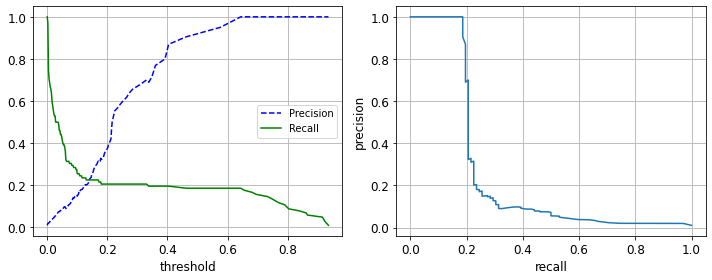

In [53]:
def plot_precision_recall_vs_threshold(clf, X, y): 
    '''plot_precision_recall_vs_threshold(clf, X)'''
    
    y_scores = clf.predict_proba(X)[:,1]
    #y_scores = rnf_clf.decision_function(X_val)
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('threshold')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(recalls,precisions)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_precision_recall_vs_threshold(clf, X_val1t, y_val1)

---

## Evaluation of the best model on the test set

- The model was trained using 10 consecutive months of transactions, exclueded 20.000 randomly selected transactions that we used as validation set.

- Here we evaluate the performance of the model on two new months of transactions (20.000 transactions). 

- We generate 20 random subsamples, each one corresponding to one month of transactions (i.e. 10.000 trans.), from the test set (i.e. bootstrap). 

- For each subsample, we use the model to select the 400 transactions more likely to be a fraud. Then, we estimate the percentage of the total fraud transactions of the month we have found. 

- As a control, we also show the average percentage of frauds we can detect by randomly selecting 400 transactions from the same subsamples.  

- Furthermore, we show the average percentage of frauds we can detect using the model from the validation set. 

### Pre-processing

In [54]:
def PreProcess(X_train, X_test):
    '''
    X_train_pp, X_test_pp = PreProcess(X_train, X_test) 

    Transform the row data using the pre-processing steps selected using the validation sets
    '''
    datasets = [X_train, X_test]
    # 1. reset index
    X_train, X_test = [reset_indexes(datasets[i]) for i in range(2)]
    # 2. transform categorical features 
    col_list = ['accountNumber','merchantId', 'merchantZip']
    le = LabelEncoderExt()
    for col in col_list:
        le.fit(X_train[col])
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

    # 3. Add time features 
    datasets = [X_train, X_test]
    X_train, X_test = [add_time(datasets[i]) for i in range(2)]

    # 4. Drop eventId
    X_train.drop(columns=['eventId'],inplace=True)
    X_test.drop(columns=['eventId'],inplace=True)

    # 5. Standardize
    ss = StandardScaler()
    X_train = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns)
    X_test  = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)
    return X_train, X_test



X_train_full_ss, X_test_ss = PreProcess(X_train_full, X_test) 

#### Training

In [55]:
# Optimized hyperparameters
clf = RandomForestClassifier(random_state=2000, n_estimators=500, n_jobs=-1,  bootstrap = False)#max_features = 4, class_weight='balanced', , n_estimators=300, max_features='auto'
clf.fit(X_train_full_ss, y_train_full) 

RandomForestClassifier(bootstrap=False, n_estimators=500, n_jobs=-1,
                       random_state=2000)

#### Evaluation

In [56]:
X_testt= X_test_ss.copy()
ev_6 = Evaluation()
ev_6.clf = clf

N = 10000 # sample size corresponding to 1 month
percent_frauds, percent_frauds_control = [], []
money_saved, total_money  = [], []
for n_tests in range(20):

    # Test set
    ii = np.random.RandomState(seed=n_tests ).permutation(np.arange(1,X_testt.shape[0],1))
    bs_index = ii[:N]
    xtt = X_testt.iloc[bs_index,:].copy()
    ytt = y_test[bs_index]
    y_val_prob = clf.predict_proba(xtt)
    s = ev_6.Res(y_val_prob[:,1], ytt)
    percent_frauds.append(s)

    #money_saved.append( ev_6.Saved_Money() )
    #ev_5.X = xtt
    #ev_5.y = ytt
    #total_money.append(ev_5.transAmount_total)
    #print(f'test set: detected {s} % ')
    
    # Control: random selection 
    ii = np.random.RandomState(seed=n_tests ).permutation(np.arange(1,len(y_test),1))
    sens = sum(y_test[ii[:400]])/sum(y_test)*100
    percent_frauds_control.append(sens)
    #print(f'random selection: detected {sens}%')
    
    
print('Average across 20 bootstrapped datasets')
print(f'1) model selection on test set {np.mean(percent_frauds)} % ')
print(f'2) random selection on test set {np.mean(percent_frauds_control)} %')
#print(f'3) model selection on validation set {np.mean(percent_frauds_cv)}')  
# print(f'4) Money saved per month {np.mean(money_saved)} over {np.mean(total_money)} GBP')  

Average across 20 bootstrapped datasets
1) model selection on test set 30.33490680959497 % 
2) random selection on test set 1.9270833333333333 %


#### Comment 
If our client was randomly selecting 400 transactions per month to check for frauds, it would detect less than the 2% of the them. On the other hand, **using my model it would detect 15 times more frauds (the 30%)!**

This classification task is challenging for many reasons: 
- the unbalance in the categories (only 1% of frauds)
- the very high detection threshold (we need to select 400 trials out of 10.000)
- fraudsters constantly optimize their strategy to escape anomaly detection strategies
- Finally, since we train the model over a certain period of time and then predict frauds from a different period (two new months), this is an **extrapolation problem**. 
Since the behaviors of the owners of the accounts and the fraudsters change over time, generalizations to future transactions are difficult.   

The model performance would be way better if we were randomly sampling the test set transactions over the same period of time as the training set. 

I am going to show that in the next session. 

---

## Model peformance: test set from the same period of time as the training set 

In [57]:
# Split the data by random sampling 
# --------------------------------
# Create a training set and two validation sets 
splitter_test = StratifiedShuffleSplit(n_splits=2, 
    test_size=20000, random_state=1000)

for train_index, test_index in splitter_test.split(data, y):
    X_train, X_test1 = data.loc[train_index], data.loc[test_index]
    y_train, y_test1 = y[train_index], y[test_index]


# Pre-processing 
# --------------------------------
X_train_control, X_test_control = PreProcess(X_train, X_test1) 

clf_2 = RandomForestClassifier(random_state=2000, n_estimators=500, n_jobs=-1,  bootstrap = False)#max_features = 4, class_weight='balanced', , n_estimators=300, max_features='auto'
clf_2.fit(X_train_control, y_train) 

# Evaluation
# --------------------------------
X_testt= X_test_control.copy()
ev_7 = Evaluation()
ev_7.clf = clf_2

N = 10000 # sample size corresponding to 1 month

percent_frauds_contr2 = [] 
money_saved, total_money  = [], []
for n_tests in range(20):

    # Test set
    ii = np.random.RandomState(seed=n_tests ).permutation(np.arange(1,X_testt.shape[0],1))
    bs_index = ii[:N]
    xtt = X_testt.iloc[bs_index,:].copy()
    ytt = y_test1[bs_index]
    y_val_prob = clf.predict_proba(xtt)
    s = ev_7.Res(y_val_prob[:,1], ytt)
    percent_frauds_contr2.append(s)

print(f'2) random selection on test set {np.mean(percent_frauds_contr2)} %')


2) random selection on test set 91.10830032985231 %


#### Comment 
As expected, If the test data are sampled from the same period of time as the training data (cross-validation) the performance of the model raises to 91% on average. 

This confirms that the model does a pretty good job in predicting new frauds. The limitations in its performance depend on the variability of the data across time. 

---

## Summary Figure

(-5.0, 100.0)

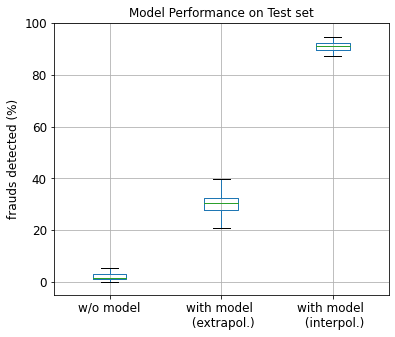

In [58]:
a = pd.DataFrame()
a['w/o model'] = percent_frauds_control # random selection
a['with model \n (extrapol.)'] = percent_frauds
a['with model \n (interpol.)'] = percent_frauds_contr2

plt.figure(figsize=(6,5))
a.boxplot()
plt.ylabel('frauds detected (%)')
plt.title('Model Performance on Test set')
plt.ylim([-5,100])

# task: select the 400 transactions over 10000 with the higer probability to be a fraud
#txt="task: select the 400 transactions over 10000 with the higer probability to be a fraud"
#plt.figtext(0.4, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)

## Summary 
The goal of this study was the selection of a machine learning pipeline to predict the probability of frauds based on trasactions features. 

I created many diffent new features and tested several classification algorithms (supervised and unsupervised). 

I found that a Random Forest Classifier produces the best performance. 

I optimized the hyperparameters of this classifier and estimated the performance on the test set. 

Overall, using this model our client will detect 15 times more frauds than by randomly selecting the transactions to check. 

___